In [6]:
import chainer
from chainer import links as L
from chainer import functions as F
from chainer import optimizers

from generate_input import load_images_from_folder

from chainer import reporter

from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import  initializers, iterators, optimizers, serializers
from chainer.training import extensions

import numpy as np

In [2]:
class MRICNN(chainer.Chain):
    def __init__(self, x_shape):
        super(MRICNN, self).__init__()
        with self.init_scope():
            n_out = int(x_shape[0]*x_shape[1])
            self.fc1 = L.Linear(None, n_out)
            self.fc2 = L.Linear(None, n_out)
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=5)
            self.conv2 = L.Convolution2D(in_channels=64,out_channels=64, ksize=5, pad=1)
#             self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=7, outsize=(x_shape[0], x_shape[1]))
            self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=7)
        
    def __call__(self, x):
        h = x.reshape(x.shape[0], -1)
        
        h = self.fc1(h)
        h = F.tanh(h)
        h = self.fc2(h)
        h = F.tanh(h)
        h = h.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
#         print(h.shape)
        h = self.conv1(h)
        h = F.relu(h)
#         print(h.shape)
        h = self.conv2(h)
        h = F.relu(h)
#         print(h.shape)
        h = self.deconv(h)
#         print(h.shape)
        
        return h


In [3]:
def compute_cost(x, y):
    x = x[:, 0, :, :]
    cost = F.mean_squared_error(x, y)
    return cost

In [4]:
class Minimizer(chainer.Chain):
    def __init__(self, model, loss_fun):
        super(Minimizer, self).__init__()
        with self.init_scope():
            self.model = model
            
        self.loss_fun = loss_fun
        
    def forward(self, *args):
        self.y = self.model(args[0])
        self.loss = self.loss_fun(self.y, args[1])
        reporter.report({'loss':self.loss}, self)
        return self.loss

In [5]:
dir_train = '/home/genta/dataset/tiny-imagenet-200/test/images'  # Folder with images
n_im = 10000  # How many images to load
X_train, Y_train = load_images_from_folder(  # Load images for training
    dir_train,
    n_im,
    normalize=True,
    imrotate=True)
print('X_train.shape at input = ', X_train.shape)
print('Y_train.shape at input = ', Y_train.shape)

X_train.shape at input =  (40000, 64, 64, 2)
Y_train.shape at input =  (40000, 64, 64)


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)

In [10]:
n_test = X_train.shape[0]//4
train = [(i, j) for i, j in zip(X_train[n_test:, :], Y_train[n_test:, :])]
test = [(i, j) for i, j in zip(X_train[:n_test, :], Y_train[:n_test, :])]

In [11]:
predictor = MRICNN(X_train[0].shape)

In [24]:
serializers.load_npz('./result/model_epoch-100', predictor)

In [55]:
i = 100

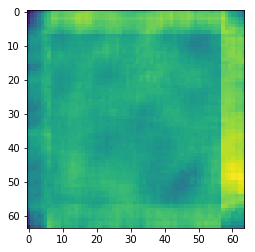

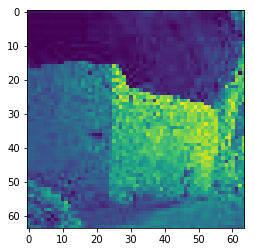

In [56]:
out = predictor(X_train[i, :][np.newaxis, :])

plt.imshow(out.data[0][0])
plt.show()

plt.imshow(Y_train[i])
plt.show()

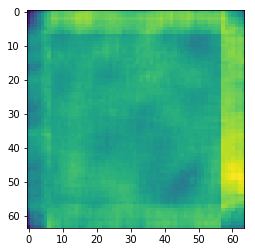

In [47]:
plt.imshow(out.data[1, 0])